# Plotting with Matplotlib and Cartopy

In addition to supporting the HoloViz ecosystem of plotting packages via the `.plot()` accessors, UXarray also provides functionality to represent unstructured grids in formats that are accepted by Matplotlib and Cartopy.

This guide covers:
1. Rasterizing Data onto a Cartopy [``GeoAxes``](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html)
2. Visualizing Data with [``PolyCollection``](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PolyCollection)
3. Visualizing Grid Topology with [``LineCollection``](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.LineCollection)

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree

import uxarray as ux

In [4]:
base_path = "../../test/meshfiles/mpas/QU/480/"
grid_path = base_path + "grid.nc"
data_path = base_path + "data.nc"

uxds = ux.open_dataset(grid_path, data_path)

## Matplotlib and Cartopy Background

To support Matplotlib and Cartopy workflows, UXarray has chosen to provide the necessary conversion functions to represent unstructured grids in formats that can be interpreted by these packages. This means that you as the user are responsible for setting up the figure, adding colorbar, and configuring other aspects of the plotting workflow. Because of this, we will not cover these topics in detail, but reccomend reviewing the following resources:
- [**Pythia Foundations:** Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html)
- [**Pythia Foundations: Cartopy**](https://foundations.projectpythia.org/core/cartopy.html)
- [Matplotlib Quickstart Guide](https://matplotlib.org/stable/users/explain/quick_start.html)


## Rasterization

UXarray can rapidly translate face-centered data into a raster image that can be displayed directly on a Cartopy [``GeoAxes``](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html).


UXarray currently supports a nearest-neighbor based rasterization method, which converts each screen-space pixel from the [``GeoAxes``](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html) into a geographic coordinate for sampling the underlying unstructured grid. If the pixel lies within a face in the unstructured grid, it is shaded by the corresponding face value.

The result is a 2-D array that works seamlessly with Matplotlib's ``imshow``, ``contour``, ``contourf`` and other visualization functions.


```{important}
Since the core geometry routines used internally directly sample the underlying unstructured grid using ``Numba``, rasterization is extremely, even on high-resolution unstructured grids
```


### Displaying Rasterized Data with `ax.imshow()`

Because rasterization yields a fully georeferenced two-dimensional array, the quickest way to render it is with Matplotlib’s `Axes.imshow()` on a Cartopy [``GeoAxes``](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html). By supplying the raster array along with the appropriate origin and extent parameters, Cartopy automatically handles projection and alignment.

```{caution}
When rasterizing a grid at a global extent, especially at higher resolutions, there may not be enough pixels to sample the entire grid thouroughly. You can consider increasing the figure size if you need more pixels.
```


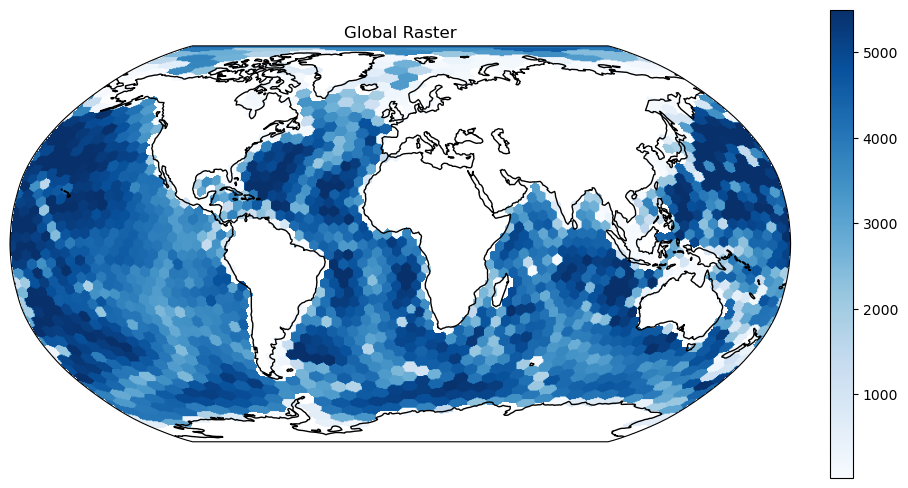

In [9]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_global()

raster = uxds["bottomDepth"].to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()

# Adding a colorbar (the examples below will not include one to keep things concise)
cbar = fig.colorbar(img, ax=ax, fraction=0.03)

When you only need to visualize a subset of your data, such as a country, basin, or smaller study area, limiting the extent of the Cartopy [``GeoAxes``](https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html) before rasterization can significantly improve performance. By setting a tighter longitude-latitude window, the pixel-to-face lookups are constrained to that region, reducing the overall number of queries. This targeted sampling speeds up rendering, lowers memory overhead, and produces a cleaner, more focused map of your area of interest.

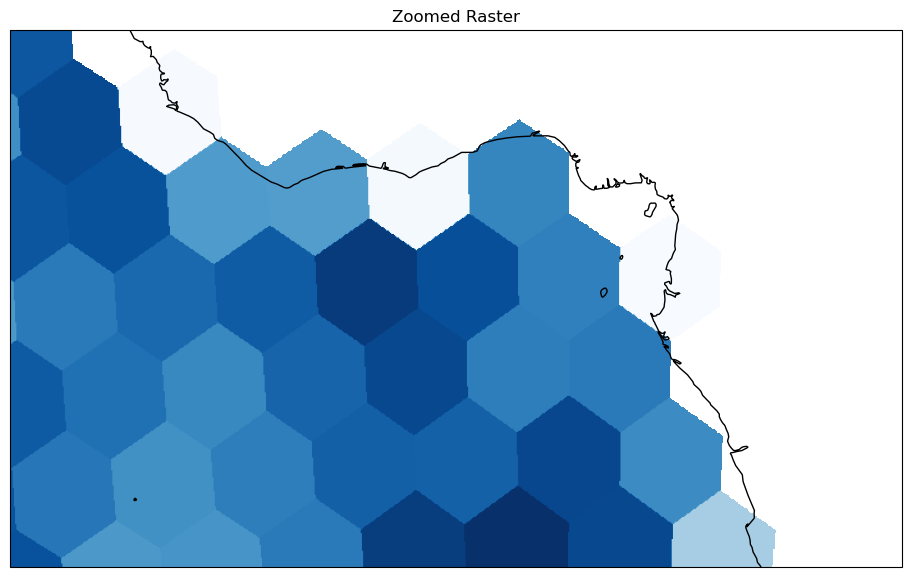

In [11]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_extent((-20, 20, -10, 10))


raster = uxds["bottomDepth"].to_raster(ax=ax)
ax.imshow(raster, cmap="Blues", origin="lower", extent=ax.get_xlim() + ax.get_ylim())
ax.set_title("Zoomed Raster")
ax.coastlines()

### Viewing Contours with `ax.contour()` and `ax.contourf()`

You can use  `ax.contour()` to draw projection-aware isolines and `ax.contourf()` to shade between levels, specifying either a contour count or explicit thresholds.

```{warning}
The contours are generated on the raster image, not the unstructured grid geometiries, which may create misleading results if not enough pixels were sampled.
```


In [18]:
levels = [0, 2000, 4000, 6000]

Text(0.5, 1.0, 'Filled Contours')

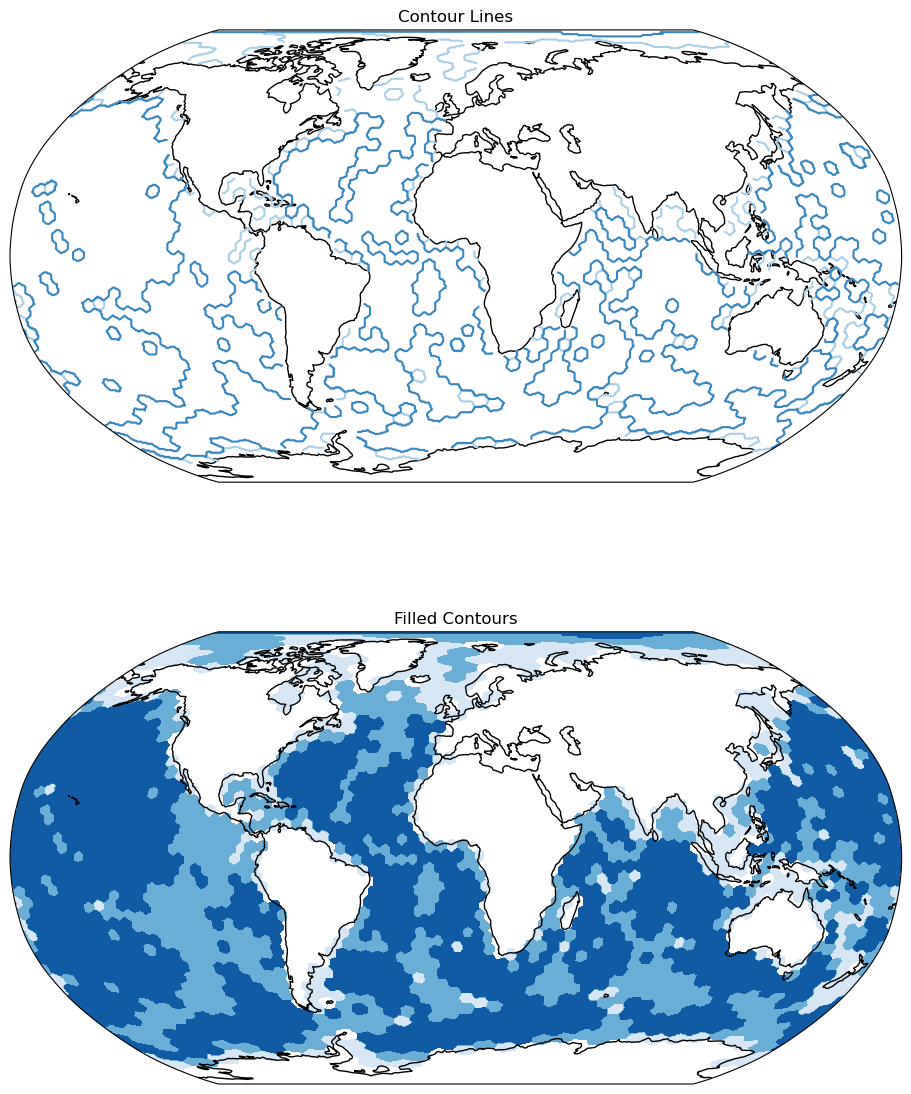

In [19]:
fig, axes = plt.subplots(
    2,
    1,
    subplot_kw={"projection": ccrs.Robinson()},
    constrained_layout=True,
    figsize=(9, 12),
)

ax1, ax2 = axes

ax1.set_global()
ax2.set_global()

ax1.coastlines()
ax2.coastlines()

raster = uxds["bottomDepth"].to_raster(ax=ax1)

# Contour Lines
ax1.contour(
    raster,
    cmap="Blues",
    origin="lower",
    extent=ax1.get_xlim() + ax1.get_ylim(),
    levels=levels,
)
ax1.set_title("Contour Lines")

# Filled Contours
ax2.contourf(
    raster,
    cmap="Blues",
    origin="lower",
    extent=ax2.get_xlim() + ax2.get_ylim(),
    levels=levels,
)
ax2.set_title("Filled Contours")

## Matplotlib Collections

Instead of directly sampling the unstructured grid, UXarray supports converting the grid into two `matplotlib.collections` classes: `PolyCollection` and `LineCollection`

```{warning}
It is reccomended to only use these collection-based plotting workflows if your grid is relatively small. For higher-resolution grids, directly rasterizing will almost always produce quicker results.
```


### Visualize Data with ``PolyCollection``

To visualize face-centered data variables, you can convert a [``UxDataArray``](https://uxarray.readthedocs.io/en/latest/generated/uxarray.UxDataArray.html#uxarray.UxDataArray) into a [``PolyCollection``](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PolyCollection), which represents each face as a polygon, shaded by its corresponding data value.

In [20]:
poly_collection = uxds["bottomDepth"].to_polycollection()

Text(0.5, 1.0, 'PolyCollection')

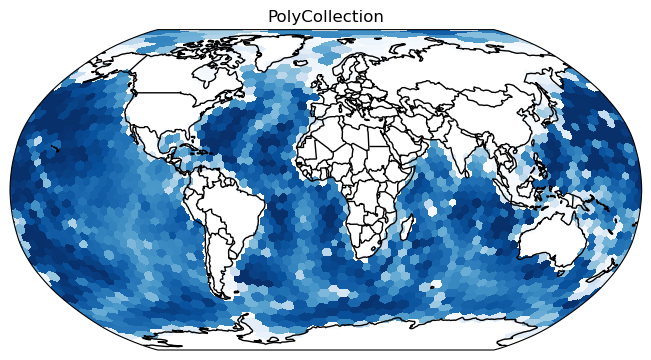

In [21]:
# disables grid lines
poly_collection.set_antialiased(False)

poly_collection.set_cmap("Blues")

fig, ax = plt.subplots(
    1,
    1,
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=ccrs.Robinson()),
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

ax.add_collection(poly_collection)
ax.set_global()
plt.title("PolyCollection")

### Visualize Grid Topology with ``LineCollection``

To visualize the unstructured grid geometry, you can convert a [``Grid``](https://uxarray.readthedocs.io/en/latest/generated/uxarray.Grid.html#uxarray.Grid) into a [``LineCollection``](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.LineCollection), which stores the edges of the unstructured grid.

```{important}
Since the transform for the ``LineCollection`` and ``PolyCollection`` are set to ``ccrs.Geodetic()``, the edges and polygons are drawn correctly on the surface of a sphere and properly at the antimeridian.
```


In [22]:
line_collection = uxds.uxgrid.to_linecollection(colors="black", linewidths=0.5)

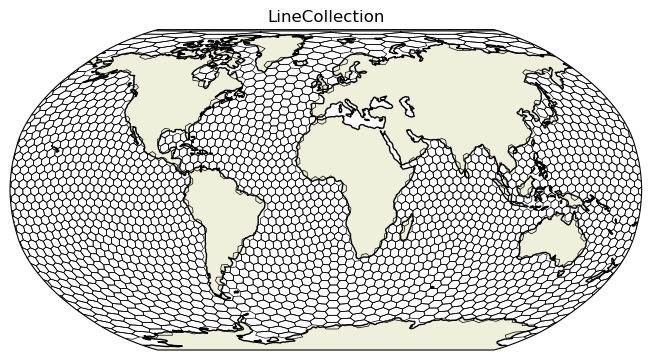

In [23]:
fig, ax = plt.subplots(
    1,
    1,
    constrained_layout=True,
    subplot_kw={"projection": ccrs.Robinson()},
)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_collection(line_collection)
ax.set_global()
ax.set_title("LineCollection")
plt.show()